Datasets loaded successfully.

Class Distribution:


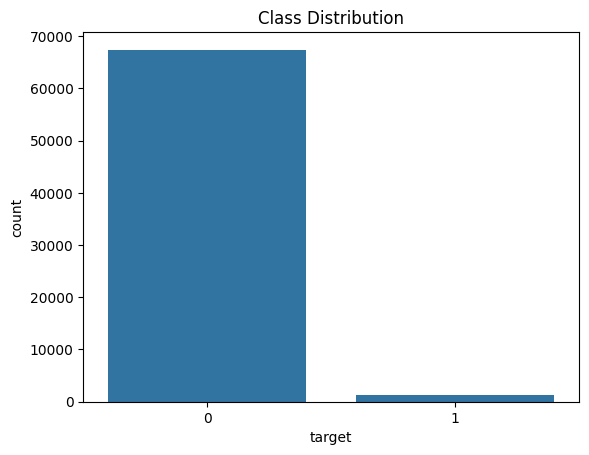


Correlation Heatmap for Numerical Features:


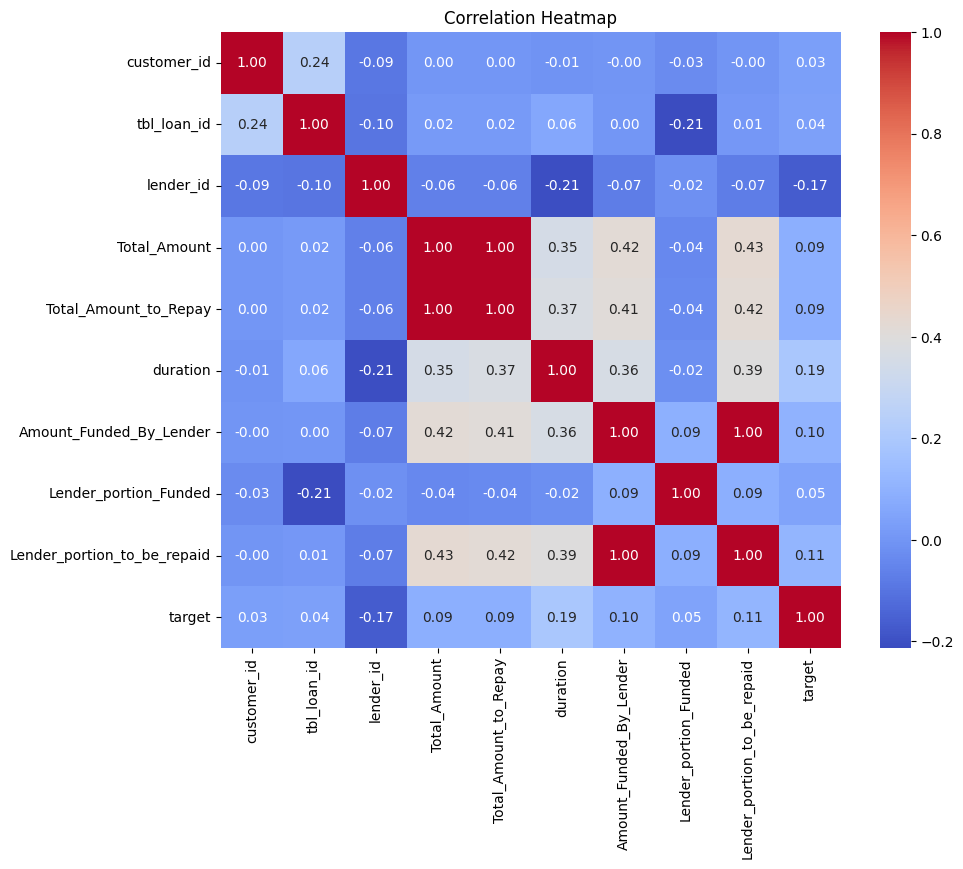

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3370/3370 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.6787 - loss: 1.8063 - val_accuracy: 0.6268 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 2/100
3370/3370 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.7927 - loss: 0.4701 - val_accuracy: 0.6743 - val_loss: 1.0314 - learning_rate: 0.0010
Epoch 3/100
3370/3370 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8358 - loss: 0.3691 - val_accuracy: 0.7705 - val_loss: 0.7321 - learning_rate: 0.0010
Epoch 4/100
3370/3370 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.8649 - loss: 0.3196 - val_accuracy: 0.8227 - val_loss: 0.5945 - learning_rate: 0.0010
Epoch 5/100
3370/3370 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8746 - loss: 0.3006 - val_accuracy: 0.7518 - val_loss: 0.8590 - learning_rate: 0.0010
Epoch 6/100
3370/3370 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8933 - loss: 0.2549 - val_accuracy: 0.8114 - val_loss: 0.6148 - learning_rate: 0.0010
Epoch 7/100
3370/3370 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step -

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import os

# 1. Load Datasets
try:
    train_data = pd.read_csv("/content/Train (1).csv")
    test_data = pd.read_csv("/content/Test (1).csv")
    economic_data = pd.read_csv("/content/economic_indicators (1).csv")
    print("Datasets loaded successfully.")
except Exception as e:
    print(f"Error loading datasets: {e}")
    raise

# 2. Exploratory Data Analysis (EDA)
# Visualize class distribution and correlation between numerical features.

def eda_visualizations(df, target_col):
    try:
        print("\nClass Distribution:")
        sns.countplot(data=df, x=target_col)
        plt.title("Class Distribution")
        plt.show()
 # Correlation heatmap
        print("\nCorrelation Heatmap for Numerical Features:")
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        corr = df[numeric_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()
    except Exception as e:
        print(f"Error in EDA visualizations: {e}")

eda_visualizations(train_data, "target")

# 3. Handle Missing Values
# Replace missing values in numerical columns with the median and categorical columns with the mode.
    for df in [train_data, test_data]:
    df.fillna(df.median(numeric_only=True), inplace=True)
    df.fillna(df.mode().iloc[0], inplace=True)


# 4. Handle Outliers
# Use IQR to clip extreme outliers in numerical columns.

def handle_outliers(df, columns):
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

numerical_cols = [
    'Total_Amount', 'Total_Amount_to_Repay', 'Amount_Funded_By_Lender',
    'Lender_portion_Funded', 'Lender_portion_to_be_repaid'
]
handle_outliers(train_data, numerical_cols)

# 5. Features and Target
# Separate input features and target labels in training data. Extract test IDs for predictions.
X_train_full = train_data.drop(columns=['ID', 'target'])
y_train_full = train_data['target']
test_ids = test_data['ID']
X_test = test_data.drop(columns=['ID'])

# Identify categorical and numerical columns
categorical_cols = X_train_full.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_full.select_dtypes(include=[np.number]).columns.tolist()

# 6. Preprocessing
# Scale numerical features and one-hot encode categorical features.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Apply preprocessing transformations to the data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# 7. Handle Class Imbalance
# Use SMOTE to balance the training data by oversampling the minority class.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_full),
    y=y_train_full
)
class_weights_dict = dict(enumerate(class_weights))

# 8. Build the Neural Network
# Define a sequential model with dense layers, batch normalization, and dropout.
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')  # Binary classification
])

# 9. Compile the Model
# Use Adam optimizer, binary cross-entropy loss, and accuracy metric.

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 10. Train the Model
# Use early stopping and learning rate reduction callbacks during training.

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

try:
    history = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=callbacks
    )
    print("Model training completed.")
except Exception as e:
    print(f"Error during training: {e}")

# 11. Evaluate the Model
# Calculate and print validation loss and accuracy.val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# 12. Classification Report
# Predict on validation data and display precision, recall, and F1-score.
y_val_pred = (model.predict(X_val) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# 13. Predictions on Test Data
# Predict probabilities for test data and convert to binary labels.
test_predictions = model.predict(X_test)
test_predictions_binary = (test_predictions > 0.5).astype(int)


# 14. Save Submission File
# Create a submission file with test IDs, predicted labels, and probabilities.
submission = pd.DataFrame({
    'ID': test_ids,
    'target': test_predictions_binary.flatten(),
    'probability': test_predictions.flatten()
})
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)
print(f"Submission file saved as '{submission_path}'")
